<a href="https://colab.research.google.com/github/anitamezzetti/financial_big_data/blob/main/HienVersion_FinBigData_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
student1 = "Anita Mezzetti"
student2 = "Hien Lê"

Complementary stuff:
* Drive Folder to save data, notebooks and models

Note: project has been linked to [Github](https://github.com/anitamezzetti/financial_big_data)!

In [3]:
from google.colab import drive
drive.mount('/content/drive') # make sure to add the .ipynb files to the Colab Notebooks folder first if not already done

Mounted at /content/drive


In [11]:
!ls "/content/drive/My Drive/Colab Notebooks" # checking the content of the folder

CHE.csv  CHN.csv  HienVersion_FinBigData_1.ipynb  JPN.csv  USA.csv


In [12]:
root = "/content/drive/My Drive/Colab Notebooks" # define name of folder

## Data

In [6]:
!pip install arrow

     |████████████████████████████████| 51kB 5.1MB/s 


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# other libraries here
import requests
import arrow

In [14]:
# The following snippet gets data for the 4 countries from a proxy API, but it seems that the database in this API is not up-to-date
# jh_data = requests.get('https://covid19api.herokuapp.com/confirmed')

# res_dict = jh_data.json()["locations"]
# df_res = pd.json_normalize(res_dict)
# df_res = df_res.drop(columns=["country_code", "latest", "province", "coordinates.latitude", "coordinates.longitude"])

# countries_of_interest = ["US", "Switzerland", "Japan", "China"]

# df_china = df_res[df_res.country == "China"].set_index("country")
# df_china = pd.DataFrame(df_china.sum(axis=0), columns=["China"]).T

# df = df_res[df_res.country.isin(countries_of_interest[:3])].set_index("country")
# df = pd.concat([df, df_china])

In [16]:
# TODO: we need to decide on a fixed end date!

countries_of_interest = ["USA", "CHE", "JPN", "CHN"]

endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-02-25"
end_date = arrow.utcnow().shift(days=-1).format("YYYY-MM-DD") # yesterday
dfs = {} # dfs of cumulative confirmed cases
for country in countries_of_interest:
  query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
  res = requests.get(query).json()
  df = pd.DataFrame(res["result"])
  df.index = df["date"]
  df.drop(columns=["date"])
  df["date"] = pd.to_datetime(df["date"])
  df["ts_in_secs"] = df["date"].astype(int)
  df["new_confirmed"] = df["confirmed"].diff().fillna(0)
  df.to_csv(f"{root}/{country}.csv")
  dfs[country] = df

In [15]:
test = dfs["JPN"]["confirmed"]
test.diff().fillna(0)

date
2020-02-25       0.0
2020-02-26      19.0
2020-02-27      26.0
2020-02-28      18.0
2020-02-29       9.0
               ...  
2020-11-30    1447.0
2020-12-01    2014.0
2020-12-02    2456.0
2020-12-03    2506.0
2020-12-04    2449.0
Name: confirmed, Length: 284, dtype: float64

## Analysis

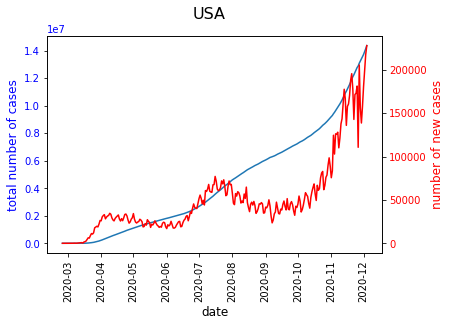

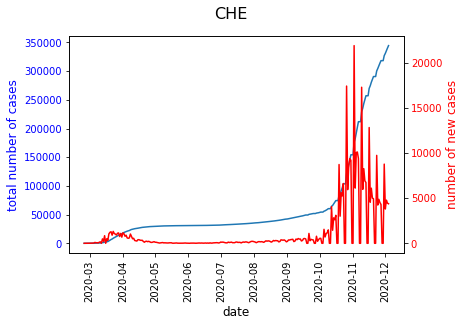

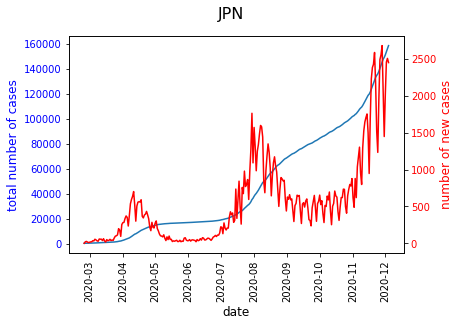

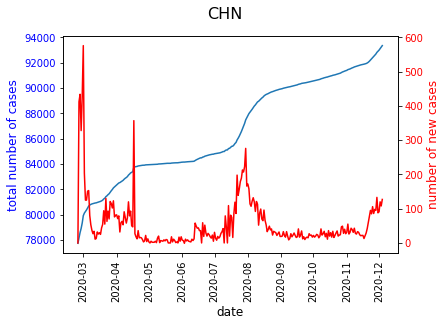

In [32]:
# first overview
for country,df in dfs.items():  
  fig,ax1 = plt.subplots()
  ax1.plot(df["date"], df["confirmed"])
  ax1.set_xlabel("date", size=12)
  ax1.tick_params(labelrotation=90, axis="x")
  color = "blue"
  ax1.set_ylabel("total number of cases", color=color, size=12)
  ax1.tick_params(axis="y", labelcolor=color)

  ax2 = ax1.twinx()
  color="red"
  ax2.plot(df["date"], df["new_confirmed"], color=color)
  ax2.set_ylabel("number of new cases", color=color, size=12)
  ax2.tick_params(axis="y", labelcolor=color)
  fig.suptitle(country, size=16)

  #fig.tight_layout()  
  plt.show()

In [ ]:
# time-series analysis
